<a href="https://colab.research.google.com/github/ALejandroCh17/Tennis-Ball-Robot/blob/daniel_branch/rally_rover_tennis_ball_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tennis Ball Image Binary Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import os
import random
from hashlib import sha256
from PIL import Image
from tensorflow.keras.optimizers import RMSprop

## Exploratory Data Analysis

In [3]:
# Define the paths to the folders containing the images
folders = [
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty'
]

**Sample Image Display**

In [4]:
# Gather all image paths from the folders
all_image_paths = []
for folder in folders:
    for image_name in os.listdir(folder):
        all_image_paths.append(os.path.join(folder, image_name))

In [5]:
# Select 5 random images from the entire dataset
selected_image_paths = random.sample(all_image_paths, 5)

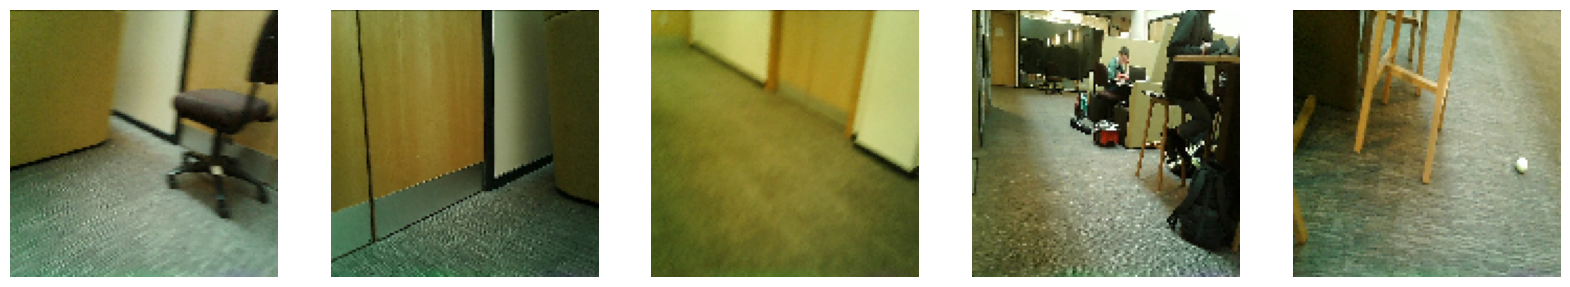

In [6]:
# Plot the selected images
plt.figure(figsize=(20, 4))
for i, img_path in enumerate(selected_image_paths):
    img = load_img(img_path, color_mode='rgb', target_size=(128, 128))  # Load and resize the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

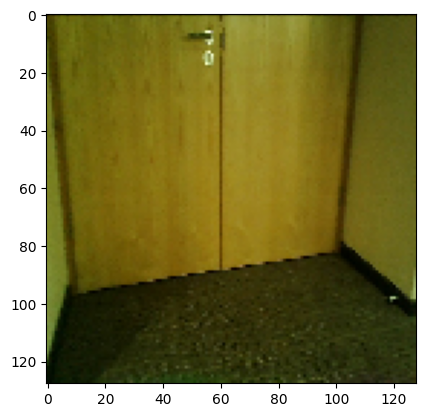

In [7]:
# Showing no ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty/empty517.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

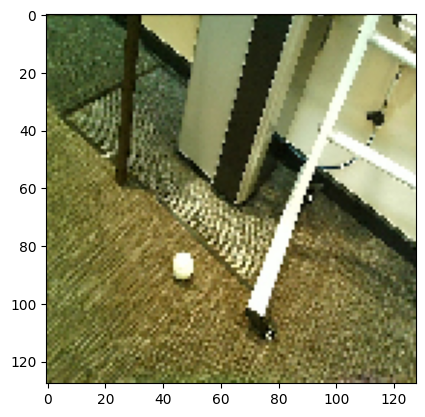

In [8]:
# Showing ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls/ball97.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

A comparison between both image confirms our expectation of a ball either present or not present.

**Label Distribution**

In [9]:
# Converts images to arrays for processing.
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder,filename), color_mode='rgb', target_size=(128, 128))
        img_arr = img_to_array(img)
        images.append(img_arr)
    return images

In [10]:
x_train_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls')
x_train_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty')
x_test_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls')
x_test_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty')

In [11]:
# Set the directory for each class
dir_train_balls = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls'
dir_train_empty = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty'
dir_test_balls = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls'
dir_test_empty = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty'

In [12]:
# Count the number of images in each directory
total_balls = len(os.listdir(dir_train_balls)) + len(os.listdir(dir_test_balls))
total_empty = len(os.listdir(dir_train_empty)) + len(os.listdir(dir_test_empty))

print(f'Balls: {total_balls}')
print(f'Empty: {total_empty}')

Balls: 446
Empty: 446


There are equal number of both types of images after modifying google drive file.

**Image Size**

In [13]:
def check_image_sizes(directories):
    unique_sizes = set()

    for directory in directories:
        for filename in os.listdir(directory):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                image_path = os.path.join(directory, filename)
                with Image.open(image_path) as img:
                    unique_sizes.add(img.size)  # img.size is a tuple (width, height)

    # If there's only one unique size in the set, all images are the same size
    return len(unique_sizes) == 1, unique_sizes

In [14]:
# Use the function and print the result
all_same_size, unique_sizes = check_image_sizes(folders)
print(f"All images across all folders are the same size: {all_same_size}")
if not all_same_size:
    print(f"Unique image sizes found across all folders: {unique_sizes}")

All images across all folders are the same size: True


## Data Preprocessing

**Removing Duplicates**

In [15]:
# Concatenating no-ball and yes-ball sets together
y_train = np.concatenate( ( np.ones(len(x_train_balls)), np.zeros(len(x_train_empty))) )
x_train = np.concatenate( (np.array(x_train_balls), np.array(x_train_empty) ) )
y_test = np.concatenate( (np.ones(len(x_test_balls)), np.zeros(len(x_test_empty))) )
x_test = np.concatenate( (np.array(x_test_balls), np.array(x_test_empty) ) )

In [16]:
# Combine the datasets
x_combined = np.concatenate((x_train, x_test))
y_combined = np.concatenate((y_train, y_test))

In [17]:
print(f'Total: {len(x_combined)}')

Total: 892


892 total images in dataset before removing duplicates

In [18]:
# Flatten the image data
flattened_images = [image.flatten() for image in x_combined]

# Hash the flattened data
hashes = [sha256(image.data.tobytes()).hexdigest() for image in flattened_images]

# Identify and remove duplicates
unique_hashes = set()
unique_images = []

for i, hash_val in enumerate(hashes):
    if hash_val not in unique_hashes:
        unique_hashes.add(hash_val)
        unique_images.append(x_combined[i])

# unique_images now contains only unique images
x_combined = np.array(unique_images)

In [19]:
print(f'Total: {len(x_combined)}')

Total: 892


892 images after. Data already had all unique images

## Data Split

In [20]:
# Shuffle the combined dataset
randomize_combined = np.arange(len(y_combined))
np.random.shuffle(randomize_combined)
x_combined = x_combined[randomize_combined]
y_combined = y_combined[randomize_combined]

In [21]:
# New Split
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_combined, y_combined, test_size=0.30, random_state=42)

# Normalize the pixel values if you haven't done it before
x_train_new = x_train_new / 255
x_test_new = x_test_new / 255

In [22]:
# Display the shapes of the resulting datasets
print("X_train shape:", x_train_new.shape)
print("X_test shape:", x_test_new.shape)
print("y_train shape:", y_train_new.shape)
print("y_test shape:", y_test_new.shape)

X_train shape: (624, 128, 128, 3)
X_test shape: (268, 128, 128, 3)
y_train shape: (624,)
y_test shape: (268,)


In [23]:
x_train_new[400:405]

array([[[[0.29411766, 0.32156864, 0.12156863],
         [0.23137255, 0.2627451 , 0.07058824],
         [0.2509804 , 0.2784314 , 0.06666667],
         ...,
         [0.9764706 , 0.99607843, 0.96862745],
         [0.9764706 , 0.99607843, 0.96862745],
         [0.9764706 , 0.99607843, 0.96862745]],

        [[0.49411765, 0.5294118 , 0.26666668],
         [0.47058824, 0.50980395, 0.2627451 ],
         [0.47843137, 0.5254902 , 0.27450982],
         ...,
         [0.972549  , 1.        , 0.972549  ],
         [0.972549  , 1.        , 0.96862745],
         [0.972549  , 1.        , 0.96862745]],

        [[0.52156866, 0.56078434, 0.27450982],
         [0.49411765, 0.5372549 , 0.2784314 ],
         [0.4392157 , 0.49411765, 0.2509804 ],
         ...,
         [0.96862745, 1.        , 0.9843137 ],
         [0.96862745, 1.        , 0.9764706 ],
         [0.9647059 , 1.        , 0.96862745]],

        ...,

        [[0.21960784, 0.3372549 , 0.1882353 ],
         [0.29411766, 0.39607844, 0.25882354]

In [24]:
y_train_new[400:405]

array([1., 1., 1., 0., 0.])

## Model Development

In [25]:
import tensorflow as tf

class SaveBeforeIncreaseCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        super(SaveBeforeIncreaseCallback, self).__init__()
        self.save_path = save_path
        self.best_val_accuracy = float('inf')  # Initialize with infinity
        self.last_val_accuracy = 0.0
        self.improved = False

    def on_epoch_end(self, epoch, logs=None):
        # Extract the current validation accuracy from the logs
        current_val_accuracy = logs.get('val_accuracy')

        # If current validation accuracy is less than the best, update the best and set improved flag
        if current_val_accuracy < self.best_val_accuracy:
            self.best_val_accuracy = current_val_accuracy
            self.improved = True

        # If it was improved previously but now increased, save the model
        elif current_val_accuracy > self.last_val_accuracy and self.improved:
            print(f"Saving model from epoch {epoch} before validation accuracy increased.")
            self.model.save(self.save_path)
            self.improved = False  # Reset the improved flag

        # Update the last_val_accuracy for the next epoch comparison
        self.last_val_accuracy = current_val_accuracy

In [40]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.5 MB/s eta 0:00:00


In [41]:
from kerastuner import HyperModel
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()

        model.add(Conv2D(filters=hp.Int('filters_1', min_value=16, max_value=64, step=16),
                         kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
                         activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D(pool_size=hp.Choice('pooling_size_1', values=[2, 3])))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

        for i in range(hp.Int('num_conv_layers', 1, 3)):
            model.add(Conv2D(filters=hp.Int(f'filters_{i+2}', min_value=32, max_value=128, step=32),
                             kernel_size=hp.Choice(f'kernel_size_{i+2}', values=[3, 5]),
                             activation='relu'))
            model.add(MaxPooling2D(pool_size=hp.Choice(f'pooling_size_{i+2}', values=[2, 3])))
            model.add(Dropout(rate=hp.Float(f'dropout_{i+2}', min_value=0.0, max_value=0.5, step=0.1)))

        model.add(Flatten())
        model.add(Dense(units=hp.Int('units_dense', min_value=64, max_value=256, step=64), activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

        return model


<ipython-input-41-e054d77fd84e>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [42]:
from kerastuner.tuners import RandomSearch

hypermodel = CNNHyperModel(input_shape=(128, 128, 3))

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hparam_tuning'
)

tuner.search_space_summary()

tuner.search(x_train_new, y_train_new, epochs=10, validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 10 Complete [00h 00m 08s]
val_accuracy: 0.9878787994384766

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 01m 29s


In [43]:
best_hps = tuner.get_best_hyperparameters()[0]
print('Best hyperparameters found were: ', best_hps.values)


Best hyperparameters found were:  {'filters_1': 64, 'kernel_size_1': 3, 'pooling_size_1': 2, 'dropout_1': 0.4, 'num_conv_layers': 3, 'filters_2': 64, 'kernel_size_2': 3, 'pooling_size_2': 2, 'dropout_2': 0.4, 'units_dense': 64, 'filters_3': 128, 'kernel_size_3': 5, 'pooling_size_3': 3, 'dropout_3': 0.0, 'filters_4': 128, 'kernel_size_4': 5, 'pooling_size_4': 2, 'dropout_4': 0.1}


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Assuming `best_hps` is the result from your hyperparameter tuning
kernelSize = best_hps.get('kernel_size_1')  # Example for getting kernel size
poolingSize = best_hps.get('pooling_size_1')  # Example for getting pooling size
dropoutRate = best_hps.get('dropout_1')  # Example for getting dropout rate
# Note: Adjust the above keys ('kernel_size_1', etc.) based on your actual hyperparameter names

model = Sequential()

# Convolutional layer 1 (hidden)
model.add(Conv2D(best_hps.get('filters_1'), kernel_size=kernelSize, activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=poolingSize))
model.add(Dropout(dropoutRate))

# Additional convolutional layers
# Assuming you dynamically create more layers based on the tuning result
num_conv_layers = best_hps.get('num_conv_layers')
for i in range(1, num_conv_layers):
    model.add(Conv2D(best_hps.get(f'filters_{i+1}'), kernel_size=best_hps.get(f'kernel_size_{i+1}'), activation='relu'))
    model.add(MaxPooling2D(pool_size=best_hps.get(f'pooling_size_{i+1}')))
    model.add(Dropout(best_hps.get(f'dropout_{i+1}')))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(best_hps.get('units_dense'), activation='relu'))
model.add(Dropout(dropoutRate))
model.add(Dense(units=16, activation='relu'))  # Assuming this remains constant
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [55]:
model.fit(x=x_train_new, y=y_train_new, validation_data=(x_test_new, y_test_new), epochs=10, callbacks=[save_before_increase_callback])

Epoch 1/10
 5/20 [======>.......................] - ETA: 0s - loss: 0.5139 - accuracy: 0.7375

20/20 [==============================] - 1s 47ms/step - loss: 0.5658 - accuracy: 0.7083 - val_loss: 0.5774 - val_accuracy: 0.7575
Epoch 2/10
20/20 [==============================] - 1s 38ms/step - loss: 0.5456 - accuracy: 0.7308 - val_loss: 0.5346 - val_accuracy: 0.7799
Epoch 3/10
20/20 [==============================] - 1s 37ms/step - loss: 0.5621 - accuracy: 0.7260 - val_loss: 0.5922 - val_accuracy: 0.6828
Epoch 4/10
20/20 [==============================] - 1s 37ms/step - loss: 0.5392 - accuracy: 0.7564 - val_loss: 0.5737 - val_accuracy: 0.7127
Epoch 5/10
20/20 [==============================] - 1s 37ms/step - loss: 0.5205 - accuracy: 0.7692 - val_loss: 0.5692 - val_accuracy: 0.7388
Epoch 6/10
20/20 [==============================] - 1s 37ms/step - loss: 0.4963 - accuracy: 0.7500 - val_loss: 0.5135 - val_accuracy: 0.7575
Epoch 7/10
20/20 [==============================] - 1s 37ms/step - loss: 0.4455 - accuracy: 0.8093 - val_loss: 0.5110 - val_accuracy: 0.7575
Epoch 8/10
20/20 [======